<a href="https://colab.research.google.com/github/JedRouffiac/TP_ML/blob/master/TP3_ML3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Jean-Eudes Rouffiac  

&nbsp;

&nbsp;



# <center> TP 3 : CNN </center>

&nbsp;

<p style="text-align:justify;"> L'objectif de ce TP est de découvrir les réseaux de neurones à convolution. Pour ce faire nous utiliserons un dataset composé d'images de deux catégories différentes : des muffins et des chihuahuas. L'objectif sera à l'aide d'un CNN, d'obtenir le meilleur score de classification possible. Nous nous intéresserons à 3 catégories de modèles : 
 </p>

1.   Un CNN classique, entraîné "from scratch" : convNet
2.   bottleneck
3.   Fine Tuning










In [2]:
from google.colab import drive
drive.mount("/content/gdrive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

import matplotlib.pyplot as plt


## ConvNet

&nbsp;

Dans un premier temps, chargeons les données. Nous allons utiliser un data set d'apprentissage, de validation ainsi qu'un data set de test. La fonction "flow_from_directory" de Keras est utilisée pour charger les données et les stocker. La fonction ImageDataGenerator de Keras est utilisée (seulement pour les données d'apprentissage du coup). Elle génère des batches en utilisant la data augementation. Cela permet d'apporter des modifications aux images :


1.   Rescale : normalisation des données
2.   Shear : permet de "distorde" les images
3.   Zoom : zoom les images
4.   Horizontal_flip : rotation de l'image horizontalement

La data augmentation permet un meilleur entraînement des données. Elle augmente le nombre de données d'entraînement en générant des images modifiées des images d'entraînements. Cela peut être des transformations affines des images (flip horizontal, vertical, etc.) ou non affines (bruit aléatoire, carrés noirs aléatoires, etc.). Cette méthode permet d'éviter d'avoir des images trop parfaites qui permettraient au réseau de neurones de généraliser. Par exemple d'utiliser l'arrière plan d'une image pour la classer. On veut que le réseau reconnaisse les formes comme un humain. Pour les images de validation et de test, elles sont juste normalisées. Enfin, toutes les images sont redimensionnées en taille (256,256). Cette étape est nécessaire car l'input d'un CNN est fixe, contrairement à un réseau de neurone récurrent par exemple.

&nbsp;



In [0]:
train_data_dir = 'gdrive/My Drive/CNN/data/train'
validation_data_dir = 'gdrive/My Drive/CNN/data/validation'
test_data_dir = 'gdrive/My Drive/CNN/data/test'

batch_size = 32

In [24]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator( 
    rescale=1. / 255,
    #shear_range=0.2,
    shear_range=50,
    zoom_range=0.2,
    horizontal_flip=True)
    #vertical_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
valid_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

### dimensions of our images.
img_width, img_height = 256,256

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

Found 568 images belonging to 2 classes.
Found 141 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


&nbsp;

Visualisons les 16 premières images de l'échantillon d'apprentissage afin de se rendre compte des images que nous avons à disposition.


&nbsp;

In [0]:
image_batch, label_batch = next(train_generator)

In [0]:
CLASS_NAMES = list(train_generator.class_indices.keys())
def show_batch(image_batch, label_batch, CLASS_NAMES):
  plt.figure(figsize=(10,10))
  for n in range(16):
      ax = plt.subplot(4,4,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n].argmax()].title())
      plt.axis('off')

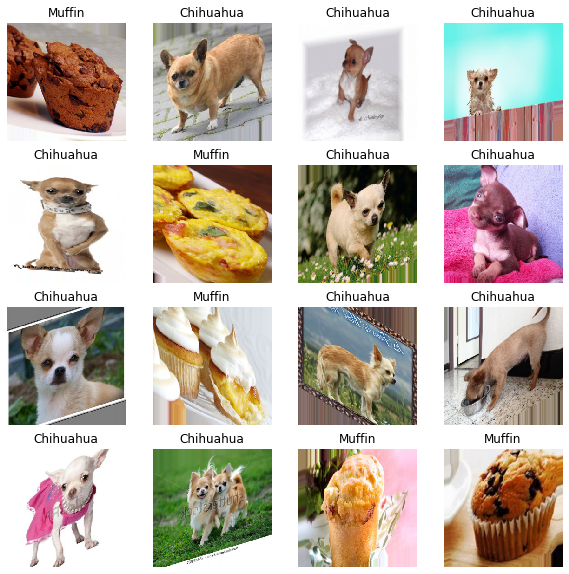

In [7]:
show_batch(image_batch, label_batch, CLASS_NAMES)

&nbsp;

On peut penser qu'un réseau de neurone sera capable de différencier assez facilement les muffins des chihuahuas. Cependant si on jette un coup d'oeil aux images de test, on peut voir que les différences entre ls muffins et les chihuahuas ne sont pas triviales, surtout que les imges du jeu de données test semblent différentes du jeu de données d'entraînement. Dans les images test, on voit les visages des chihuahas et les muffins en gros plan, alors que la majorité des images d'entraînement contiennent des chihuahas et des muffins en entier. On prévoit donc un score en test moins bon qu'en validation et en entraînement.


&nbsp;

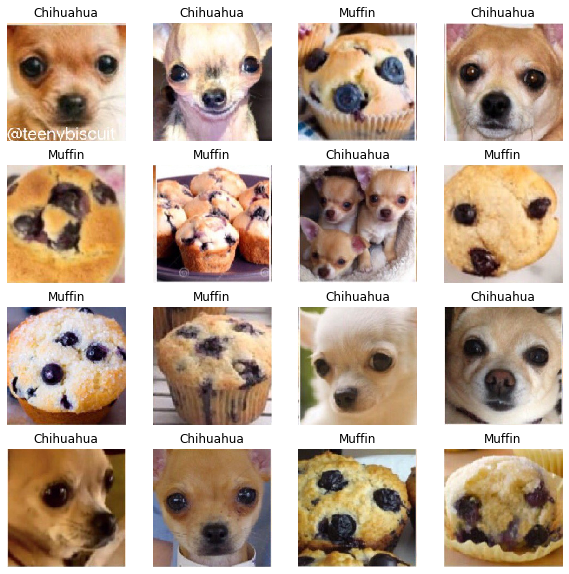

In [8]:
image_batch_test, label_batch_test = next(test_generator)
CLASS_NAMES_TEST = list(test_generator.class_indices.keys())
show_batch(image_batch_test, label_batch_test, CLASS_NAMES)

&nbsp;

Nous allons maintenant voir le 1er modèle qui est l'entraînement d'un CNN from scratch. C'est à dire que tous les poids du modèle sont initialisés aléatoirement. En fait, l'initialisation par défaut de Keras est "glorot uniform" qui initialise les poids selon une distribution uniforme entre [-limit, limit] où limit = $\sqrt{6/(fan\_in + fan\_out)}$ où fan\_in est la taille des inputs et fan\_out la taille des outputs.

&nbsp;

Nous prendrons 32 comme taille de batch et 50 comme nombre d'epochs.


&nbsp;

In [0]:
nb_train_samples = train_generator.n
nb_validation_samples = validation_generator.n
epochs = 50
batch_size = 32

&nbsp;


Les images ont une hauteur et une largeur de 256. La dimension des inputs est donc (256,256,3) car les images sont en couleurs (RGB).

&nbsp;

Le CNN que nous allons utilisé est composé successivement de : 


*   3 couches de convolutions avec pour chacune 32 filtres de taille (3,3). Chacune est suivie d'une couche de max pooling pour réduire la dimension des images en ne gardant que les informations importantes (pixels avec la plus haute intensité pour un max pooling). La taille de la fenêtre parcourant l'image est de taille (2,2) donc la hauteur et largeur de l'image est divisée par 2 après chaque couche de pooling. La fonction d'activation pour chacune des couches est Relu.
*   Une couche de convolution avec 64 filtres de taille (3,3) avec une fonction d'activation Relu, suivie d'une couche de max pooling comme pour les couches précédentes.
*   Une couche flatten qui permet de convertir la sortie du réseau de convolutions en un vecteur de dimension 1, pour qu'un MLP puisse classifier.
*   Une couche dense de 64 neurones avec une fonction d'activation Relu. S'ensuit alors un dropout. La valeur du dropout est de 0.5, ce qui signifie qu'à chaque itération, chaque neurone de la couche cachée a 50% de chance d'être désactivé. Le dropout permet d'éviter au modèle de "trop" apprendre, et donc d'éviter l'overfitting.
*   Une couche de sortie composée de 2 neurones (car 2 classes à prédire) avec donc la fonction softmax comme fonction d'activation.


&nbsp;

La fonction coût (loss) est la fonction categorical crossentropy. A chaque epoch, le modèle cherchera à diminuer la loss avec comme opitmiseur Adam.


&nbsp;

Ce modèle a été pris par défaut. Il faudrait tester différentes combinaisons en jouant avec le nombre de couches, de neurones dans les couches denses, le nombre de filtres dans les couches de convolution etc.. On pourrait lancer un benchmark en faisant varier tous ces paramètres, mais cela prendrait un temps assez conséquent. Ici, j'ai juste détaillé l'architecture du réseau pour illustrer le fonctionnement d'un CNN. Surement qu'un autre modèle donnerait de meilleurs performances.


&nbsp;



In [10]:
input_shape = (img_height, img_width, 3)
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(2))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


&nbsp;

On peut alors afficher l'architecture du réseau avec la dimension des sorties après chaque couche. On peut donc voir la réduction par 2 de la dimension après chaque couche de pooling. On remarque que le nombre de paramètres à entraîner pour les couches de convolutions n'est pas grand comparé au nombre de paramètres pour la première couche cachée dense. Après la couche flatten, l'input de la couche cachée dense est de 12544. Il y a donc 64*12544 paramètres juste pour cette couche. La feature extraction grâce aux couches de convolution n'est donc pas gourmand en temps de calcul car peu de paramètres.


&nbsp;

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9

&nbsp;


Nous allons maintenant entraîner notre modèle. Nous utiliserons les callbacks de Keras permettant à l'entraînement de s'arrêter si l'accuracy en validation n'a pas augmenté pendant 15 epochs consécutives. On sauvegarde alors les poids donnant le meilleur score en validation.

&nbsp;




In [12]:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor="val_acc", min_delta=0.01, patience =15, verbose=0)
filepath="gdrive/My Drive/CNN/best_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [early_stop, checkpoint]
model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    verbose=2,
    callbacks = callbacks_list)

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch 1/50


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


17/17 - 285s - loss: 0.7165 - acc: 0.5410 - val_loss: 0.6674 - val_acc: 0.7344
Epoch 2/50
Epoch 1/50
17/17 - 21s - loss: 0.6076 - acc: 0.6940 - val_loss: 0.5023 - val_acc: 0.7344
Epoch 3/50
Epoch 1/50
17/17 - 20s - loss: 0.5168 - acc: 0.7649 - val_loss: 0.5126 - val_acc: 0.7109
Epoch 4/50
Epoch 1/50
17/17 - 19s - loss: 0.3732 - acc: 0.8507 - val_loss: 0.3914 - val_acc: 0.7812
Epoch 5/50
Epoch 1/50
17/17 - 20s - loss: 0.4004 - acc: 0.8377 - val_loss: 0.3414 - val_acc: 0.8438
Epoch 6/50
Epoch 1/50
17/17 - 19s - loss: 0.3302 - acc: 0.8545 - val_loss: 0.2938 - val_acc: 0.8516
Epoch 7/50
Epoch 1/50
17/17 - 19s - loss: 0.3368 - acc: 0.8511 - val_loss: 0.2642 - val_acc: 0.8594
Epoch 8/50
Epoch 1/50
17/17 - 18s - loss: 0.3565 - acc: 0.8694 - val_loss: 0.3909 - val_acc: 0.8203
Epoch 9/50
Epoch 1/50
17/17 - 19s - loss: 0.3612 - acc: 0.8657 - val_loss: 0.3202 - val_acc: 0.8516
Epoch 10/50
Epoch 1/50
17/17 - 19s - loss: 0.3161 - acc: 0.8769 - val_loss: 0.3693 - val_acc: 0.8750
Epoch 11/50
Epoch 1/

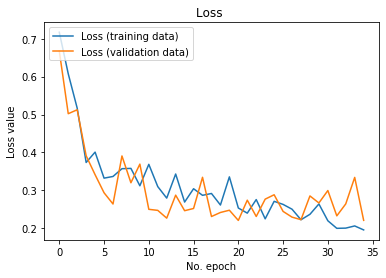

In [14]:
# Plot history: Loss
plt.plot(model.history.history['loss'], label='Loss (training data)')
plt.plot(model.history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss ')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Unrecognized location 'bottom left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


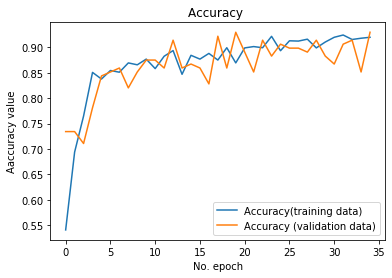

In [17]:
# Plot history: Accuracy
plt.plot(model.history.history['acc'], label='Accuracy(training data)')
plt.plot(model.history.history['val_acc'], label='Accuracy (validation data)')
plt.title('Accuracy ')
plt.ylabel('Aaccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="bottom left")
plt.show()

&nbsp;

L'entraînement s'est donc arrêter à la 35ème epoch car il n'y a pas eu d'amélioration sur le score en validation de l'epoch 21. On peut voir qu'à partir de l'epoch 5, le score en validation se stabilise entre 85% et 92%. L'algorithme a donc bien convergé.


&nbsp;

On peut alors charger le meilleur modèle obtenu et regarder le score de classification pour les données de validation et les données test.

&nbsp;

In [19]:
import tensorflow as tf
best_model = tf.keras.models.load_model("gdrive/My Drive/CNN/best_weights.hdf5")
validation_result = best_model.evaluate(validation_generator, verbose = 0)
test_result = best_model.evaluate(test_generator, verbose = 0)
print('\nScore sur les données de validation : %.2f' %(validation_result[1]))
print('\nScore sur les données test : %.2f' %(test_result[1]))


Score sur les données de validation : 0.94

Score sur les données test : 0.44


&nbsp;

Comme on s'y attendait, le score sur les données de validation est bon (94%), mais le score sur les données test ne l'est pas puisqu'il fait moins bien que le hasard. On peut expliquer cela par la petite taille du data set d'entraînement. Les images du data set de validation sont semblables à celles du jeu d'entraînement, mais différentes du jeu de données test. 


&nbsp;

Nous testons maintenant un nouveau modèle qui est LeNet, le réseau de neurones à convolutions élaboré pour reconnaître les chiffres. 


&nbsp;

In [30]:
model = Sequential()
model.add(Conv2D(6, kernel_size=(5,5), strides=(1, 1), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
model.add(Conv2D(16, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'))
#model.add(Conv2D(120, kernel_size=(5, 5), strides=(1, 1), activation='tanh', padding='valid'))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(84, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

batch_size = 32
epochs = 50

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor="val_acc", min_delta=0.01, patience =15, verbose=0)
filepath="gdrive/My Drive/CNN/best_weights_lenet.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
callbacks_list = [early_stop, checkpoint]
model.fit(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    verbose=2,
    callbacks = callbacks_list)

import tensorflow as tf
best_model = tf.keras.models.load_model("gdrive/My Drive/CNN/best_weights_lenet.hdf5")
validation_result = best_model.evaluate(validation_generator, verbose = 0)
test_result = best_model.evaluate(test_generator, verbose = 0)
print('\nScore sur les données de validation : %.2f' %(validation_result[1]))
print('\nScore sur les données test : %.2f' %(test_result[1]))

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


Epoch 1/50
17/17 - 22s - loss: 1.2250 - acc: 0.5330 - val_loss: 0.5275 - val_acc: 0.7578
Epoch 2/50
Epoch 1/50
17/17 - 21s - loss: 0.4576 - acc: 0.8086 - val_loss: 0.3028 - val_acc: 0.8672
Epoch 3/50
Epoch 1/50
17/17 - 20s - loss: 0.3853 - acc: 0.8394 - val_loss: 0.3042 - val_acc: 0.8672
Epoch 4/50
Epoch 1/50
17/17 - 20s - loss: 0.3839 - acc: 0.8370 - val_loss: 0.2826 - val_acc: 0.8828
Epoch 5/50
Epoch 1/50
17/17 - 19s - loss: 0.3326 - acc: 0.8998 - val_loss: 0.3396 - val_acc: 0.8125
Epoch 6/50
Epoch 1/50
17/17 - 18s - loss: 0.3173 - acc: 0.8647 - val_loss: 0.3804 - val_acc: 0.8203
Epoch 7/50
Epoch 1/50
17/17 - 19s - loss: 0.3300 - acc: 0.8543 - val_loss: 0.2796 - val_acc: 0.8672
Epoch 8/50
Epoch 1/50
17/17 - 19s - loss: 0.3295 - acc: 0.8530 - val_loss: 0.2854 - val_acc: 0.8672
Epoch 9/50
Epoch 1/50
17/17 - 18s - loss: 0.3192 - acc: 0.8787 - val_loss: 0.2792 - val_acc: 0.8984
Epoch 10/50
Epoch 1/50
17/17 - 18s - loss: 0.3108 - acc: 0.8745 - val_loss: 0.3275 - val_acc: 0.8516
Epoch 11/5

&nbsp;

On trouve alors encore une fois un score en validation de 94%, mais un score en test qui est de 56%, ce qui est mieux que précédemment. Cette fois ci le modèle prédit mieux les données test que le hasard.

Dans les parties suivantes, nous utiliserons cela des réseaux de neurones déjà entraînés sur plusieurs millions d'images afin de palier le problème de manque de données.


&nbsp;



La fonction suivante permet de predire la classe d'une image. La fonction renvoie l'image ainsi que sa classe associée.


&nbsp;

In [0]:
def predict_image(img_path):
    img = load_img(img_path,target_size=(img_height, img_width))
    x = img_to_array(img)
    x = x/255
    x = x.reshape((1,) + x.shape)
    plt.imshow(img)
    print([name for name, age in train_generator.class_indices.items() if age == best_model.predict_classes(x)[0]][0])

chihuahua


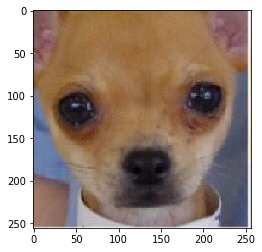

In [40]:
predict_image('gdrive/My Drive/CNN/data/test/chihuahua/image1.jpg')

&nbsp;

## Bottleneck features


### VGG16

&nbsp;

En fait, comme nous possédons peu de données (moins de 1000), il est difficile pour un réseau de neurones entraîné sur ces données de dégager des features. On peut alors utiliser un réseau pré-entraîné sur un gros volume de données. Ce réseau aura alors déjà appris des features utiles pour la majorité des problèmes d'imagerie. Cela permettrait d'avoir un taux d'erreur en classification plus faible qu'un réseau entraîné seulement sur les données que nous possédons.


&nbsp;

Nous utiliserons dans cette partie le réseau VGG16, pré entraîné sur le jeu de données ImageNet. ImageNet contient plusieurs millions d'images et sans doutes un plus grand nombre d'images de chihuahuas et de muffins que ce que nous possédons. Nottament des images de tête de chihuahas et des mufins en gros plan. Ce réseau aura donc appris à extraire les features utiles pour notre problème de classification.


&nbsp;

L'architecture du réseau VGG16 est la suivante :

&nbsp;


![Archi_vgg16](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png) 


&nbsp;

L'idée sera alors de se servir de la partie convolution du modèle. On ne se servira donc pas de la partie fully connected + softmax de VGG16. On passera donc nos données d'entraînement, de validation, ainsi que de test dans le modèle. On obtiendra alors 3 arrays (train, validation et test) correspondant à la sortie de la dernière fonction d'activation de VGG16, celle juste avant la couche fully-connected. La méthode bottleneck permet de faire un pre processing de nos données.

Nos données ont donc subit un pre processing et peuvent maintenant être utilisées pour créer un modèle de classification avec la méthode de notre choix (MLP, SVM, KNN, etc). Nous testerons avec la méthode SVM.

On ne reprend pas les données de la partie précédente car il ne faut pas que nos données subissent de la data augmentation.


In [0]:
from tensorflow.keras import applications
from tensorflow.keras.applications.vgg16 import preprocess_input

&nbsp;

On télécharge alors les poids du modèle VGG16 appris sur ImageNet en enlevant la partie fully connected.

&nbsp;



In [10]:
modelVGG16 = applications.VGG16(include_top=False, weights='imagenet', pooling='max')

58892288/58889256 [==============================] - 2s 0us/step


&nbsp;

On génère nos données avec ImageDataGenerator, cette fois ci on n'utilise donc pas de data augmentation

&nbsp;

In [12]:
%%time
img_width, img_height = 299,299

datagen = ImageDataGenerator()
train_generator = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=train_data_dir, class_mode='categorical')
validation_generator = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=validation_data_dir, class_mode='categorical')
test_generator = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=test_data_dir, class_mode='categorical')

Found 568 images belonging to 2 classes.
Found 141 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
CPU times: user 23.3 ms, sys: 11.2 ms, total: 34.5 ms
Wall time: 308 ms


&nbsp;

Dans le code ci-dessous, on passe dans le réseau VGV16 les données qu'on sauvegarde dans des tableaux. C'est la partie pre processing de nos données. La fonction preprocess_input est une fonction de keras liée à VGG16 qui gère les images de façon à ce qu'elles puissent être passées dans le réseau.

&nbsp;

In [13]:
%%time
train_data = []
train_data_processed = []
train_target = []

for i in range(len(train_generator)):
    (data,target) = train_generator.next()
    train_data.append(data)
    train_data_processed.append(modelVGG16.predict(preprocess_input(data)))
    train_target.append(target)


validation_data = []
validation_data_processed = []
validation_target = []

for i in range(len(validation_generator)):
    (data,target) = validation_generator.next()
    validation_data.append(data)
    validation_data_processed.append(modelVGG16.predict(preprocess_input(data)))
    validation_target.append(target)


test_data = []
test_data_processed = []
test_target = []

for i in range(len(test_generator)):
    (data,target) = test_generator.next()
    test_data.append(data)
    test_data_processed.append(modelVGG16.predict(preprocess_input(data)))
    test_target.append(target)


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


CPU times: user 21.6 s, sys: 6.76 s, total: 28.3 s
Wall time: 28.7 s


In [0]:
import numpy as np
train_data = np.concatenate(train_data)
validation_data = np.concatenate(validation_data)
test_data = np.concatenate(test_data)
train_data_processed = np.concatenate(train_data_processed)
validation_data_processed = np.concatenate(validation_data_processed)
test_data_processed = np.concatenate(test_data_processed)
train_target = np.concatenate(train_target)
validation_target = np.concatenate(validation_target)
test_target = np.concatenate(test_target)

&nbsp;

#### SVM



&nbsp;

On peut alors entraîner un SVM afin de classer nos données. Dans cette partie les données de validation sont finalement comme des données test car elles n'ont pas eu d'influence sur le modèle. On n'a pas chercher à trouver les hyper paramètres optimaux de la fonction SVM.

&nbsp;

In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

train_target_sklearn = np.argmax(train_target,axis=1)
validation_target_sklearn = np.argmax(validation_target,axis=1)
test_target_sklearn = np.argmax(test_target,axis=1)

clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())])

clf.fit(train_data_processed,train_target_sklearn)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [16]:
print("Score sur les données d'apprentissage : %.2f" %(clf.score(train_data_processed,train_target_sklearn)))
print("\nScore sur les données de validation : %.2f" %(clf.score(validation_data_processed,validation_target_sklearn)))
print("\nScore sur les données test : %.2f" %(clf.score(test_data_processed,test_target_sklearn)))

Score sur les données d'apprentissage : 1.00

Score sur les données de validation : 0.99

Score sur les données test : 0.88


&nbsp;

On obtient alors des résultats nettement meilleures que dans la partie précédente. On obtient 100% de bonnes détections sur les données d'entraînement et 99% sur les données de validation, il n'y a donc pas d'overfitting. On obtient 88% de score sur les données test, qui rappelons le sont plus difficiles à discriminer.

&nbsp;


La méthode pour prédire de nouvelles données est donc d'extraire les features avec VVG16 en récupérant la sortie de la fonction d'activation de la dernière couche de convolution. On utilise ensuite le discrimnateur entraîné avec une SVM.


&nbsp;


Grâce à UMAP, une méthode de réduction de dimension comme t-SNE, affichons les données d'entraînement et les données de validation (données de la sortie du modèle VGG16).


&nbsp;

In [0]:
data = np.concatenate((train_data,validation_data))
data_processed = np.concatenate((train_data_processed,validation_data_processed))
targets_sklearn = np.concatenate((train_target_sklearn,validation_target_sklearn))

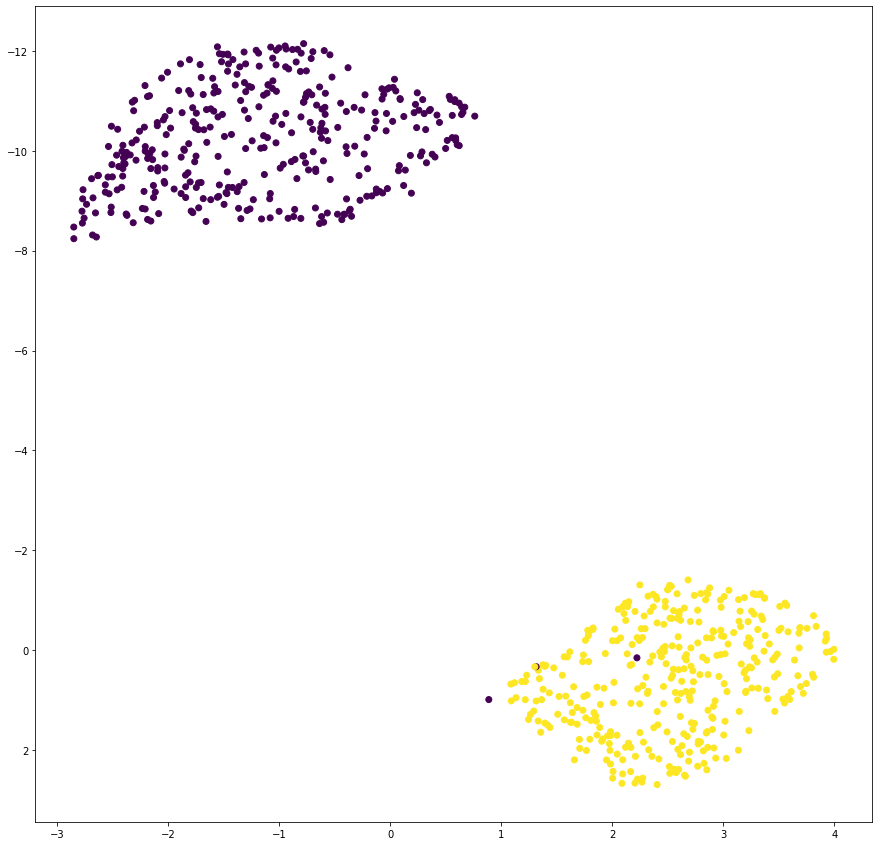

In [44]:
import umap
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.sparse import csgraph

embedding = umap.UMAP()
data_umaped = embedding.fit_transform(data_processed)
plt.figure(figsize=(15,15))
plt.scatter(data_umaped[:,1],data_umaped[:,0],c=targets_sklearn)
plt.gca().invert_yaxis()

&nbsp;

On peut voir que les données forment très clairement 2 clusters, l'un pour les chihuahas et un pour les muffins. On peut voir 3 images qui sont regroupées dans la mauvaise classe. Elles sont sûrement responsables des 1% d'erreur en validation


&nbsp;

Nous avons vu dans le cours d'autres modèles pré entraînés autre que VGG16. Nous allons en tester quelque uns pour voir les performances et pour pouvoir comparer les résultats obtenus.




&nbsp;

### ResNet



Ci-dessous, nous reprenons le même code que précédemment, en utilisant cette fois ci le modèle pré entraîné sur ImageNet : ResNet152.


&nbsp;

In [21]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras import applications
from tensorflow.keras.applications.resnet import preprocess_input



modelResNet152 = applications.resnet.ResNet152(include_top=False, weights='imagenet', pooling='max')


img_width, img_height = 224,224

datagen = ImageDataGenerator()
train_generator = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=train_data_dir, class_mode='categorical')
validation_generator = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=validation_data_dir, class_mode='categorical')
test_generator = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=test_data_dir, class_mode='categorical')



train_data = []
train_data_processed = []
train_target = []

for i in range(len(train_generator)):
    (data,target) = train_generator.next()
    train_data.append(data)
    train_data_processed.append(modelResNet152.predict(preprocess_input(data)))
    train_target.append(target)


validation_data = []
validation_data_processed = []
validation_target = []

for i in range(len(validation_generator)):
    (data,target) = validation_generator.next()
    validation_data.append(data)
    validation_data_processed.append(modelResNet152.predict(preprocess_input(data)))
    validation_target.append(target)


test_data = []
test_data_processed = []
test_target = []

for i in range(len(test_generator)):
    (data,target) = test_generator.next()
    test_data.append(data)
    test_data_processed.append(modelResNet152.predict(preprocess_input(data)))
    test_target.append(target)



train_data = np.concatenate(train_data)
validation_data = np.concatenate(validation_data)
test_data = np.concatenate(test_data)
train_data_processed = np.concatenate(train_data_processed)
validation_data_processed = np.concatenate(validation_data_processed)
test_data_processed = np.concatenate(test_data_processed)
train_target = np.concatenate(train_target)
validation_target = np.concatenate(validation_target)
test_target = np.concatenate(test_target)

Found 568 images belonging to 2 classes.
Found 141 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [22]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

train_target_sklearn = np.argmax(train_target,axis=1)
validation_target_sklearn = np.argmax(validation_target,axis=1)
test_target_sklearn = np.argmax(test_target,axis=1)

clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())])

clf.fit(train_data_processed,train_target_sklearn)

print("\n\nScore sur les données d'apprentissage : %.2f" %(clf.score(train_data_processed,train_target_sklearn)))
print("\nScore sur les données de validation : %.2f" %(clf.score(validation_data_processed,validation_target_sklearn)))
print("\nScore sur les données test : %.2f" %(clf.score(test_data_processed,test_target_sklearn)))



Score sur les données d'apprentissage : 1.00

Score sur les données de validation : 0.99

Score sur les données test : 1.00


&nbsp;


Nous obtenons alors des performances excellentes, puisque en apprentissage et en test, nous avons un score de 100%. En validation, nous obtenons 99%. Les performances sont donc grandement supérieures à VGG16.

&nbsp;





### NasNet

In [23]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras import applications
from tensorflow.keras.applications.nasnet import preprocess_input
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



model_NasNet = applications.nasnet.NASNetLarge(include_top=False, weights='imagenet', pooling='max')


img_width, img_height = 331,331

datagen = ImageDataGenerator()
train_generator = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=train_data_dir, class_mode='categorical')
validation_generator = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=validation_data_dir, class_mode='categorical')
test_generator = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=test_data_dir, class_mode='categorical')



train_data = []
train_data_processed = []
train_target = []

for i in range(len(train_generator)):
    (data,target) = train_generator.next()
    train_data.append(data)
    train_data_processed.append(model_NasNet.predict(preprocess_input(data)))
    train_target.append(target)


validation_data = []
validation_data_processed = []
validation_target = []

for i in range(len(validation_generator)):
    (data,target) = validation_generator.next()
    validation_data.append(data)
    validation_data_processed.append(model_NasNet.predict(preprocess_input(data)))
    validation_target.append(target)


test_data = []
test_data_processed = []
test_target = []

for i in range(len(test_generator)):
    (data,target) = test_generator.next()
    test_data.append(data)
    test_data_processed.append(model_NasNet.predict(preprocess_input(data)))
    test_target.append(target)



train_data = np.concatenate(train_data)
validation_data = np.concatenate(validation_data)
test_data = np.concatenate(test_data)
train_data_processed = np.concatenate(train_data_processed)
validation_data_processed = np.concatenate(validation_data_processed)
test_data_processed = np.concatenate(test_data_processed)
train_target = np.concatenate(train_target)
validation_target = np.concatenate(validation_target)
test_target = np.concatenate(test_target)


train_target_sklearn = np.argmax(train_target,axis=1)
validation_target_sklearn = np.argmax(validation_target,axis=1)
test_target_sklearn = np.argmax(test_target,axis=1)

clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())])

clf.fit(train_data_processed,train_target_sklearn)

print("\n\nScore sur les données d'apprentissage : %.2f" %(clf.score(train_data_processed,train_target_sklearn)))
print("\nScore sur les données de validation : %.2f" %(clf.score(validation_data_processed,validation_target_sklearn)))
print("\nScore sur les données test : %.2f" %(clf.score(test_data_processed,test_target_sklearn)))

Found 568 images belonging to 2 classes.
Found 141 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))




Score sur les données d'apprentissage : 1.00

Score sur les données de validation : 0.99

Score sur les données test : 1.00


&nbsp;


Nous obtenons exactement les mêmes performances que pour ResNet.

&nbsp;

### DenseNet

In [19]:
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras import applications
from tensorflow.keras.applications.densenet import preprocess_input
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



model_DenseNet = applications.densenet.DenseNet201(include_top=False, weights='imagenet', pooling='max')



img_width, img_height = 224,224

datagen = ImageDataGenerator()
train_generator = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=train_data_dir, class_mode='categorical')
validation_generator = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=validation_data_dir, class_mode='categorical')
test_generator = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=test_data_dir, class_mode='categorical')



train_data = []
train_data_processed = []
train_target = []

for i in range(len(train_generator)):
    (data,target) = train_generator.next()
    train_data.append(data)
    train_data_processed.append(model_DenseNet.predict(preprocess_input(data)))
    train_target.append(target)


validation_data = []
validation_data_processed = []
validation_target = []

for i in range(len(validation_generator)):
    (data,target) = validation_generator.next()
    validation_data.append(data)
    validation_data_processed.append(model_DenseNet.predict(preprocess_input(data)))
    validation_target.append(target)


test_data = []
test_data_processed = []
test_target = []

for i in range(len(test_generator)):
    (data,target) = test_generator.next()
    test_data.append(data)
    test_data_processed.append(model_DenseNet.predict(preprocess_input(data)))
    test_target.append(target)



train_data = np.concatenate(train_data)
validation_data = np.concatenate(validation_data)
test_data = np.concatenate(test_data)
train_data_processed = np.concatenate(train_data_processed)
validation_data_processed = np.concatenate(validation_data_processed)
test_data_processed = np.concatenate(test_data_processed)
train_target = np.concatenate(train_target)
validation_target = np.concatenate(validation_target)
test_target = np.concatenate(test_target)


train_target_sklearn = np.argmax(train_target,axis=1)
validation_target_sklearn = np.argmax(validation_target,axis=1)
test_target_sklearn = np.argmax(test_target,axis=1)

clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())])

clf.fit(train_data_processed,train_target_sklearn)

print("\n\nScore sur les données d'apprentissage : %.2f" %(clf.score(train_data_processed,train_target_sklearn)))
print("\nScore sur les données de validation : %.2f" %(clf.score(validation_data_processed,validation_target_sklearn)))
print("\nScore sur les données test : %.2f" %(clf.score(test_data_processed,test_target_sklearn)))


74842112/74836368 [==============================] - 2s 0us/step
Found 568 images belonging to 2 classes.
Found 141 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))




Score sur les données d'apprentissage : 1.00

Score sur les données de validation : 0.99

Score sur les données test : 1.00


&nbsp;


Encore une fois, nous obtenons 100% en apprentissage et en test, et 99% en validation. Nous allons maintenant tester un dernier modèle qui est à l'heure actuelle un des modèles qui obtient les meilleures performances en classification sur les données d'ImageNet.

&nbsp;

&nbsp;


### EfficientNet

&nbsp;

&nbsp;

Keras n'a pas encore implémenté ce réseau. Nous utiliserons un dépot github d'une personne qui a implémenté le réseau. On pourra alors charger comme précédemment le modèle et passer nos données dans le réseau afin de récupérer la dernière couche de convolution. On utilisera alors comme précédemment un discriminateur SVM pour la classficiation.

&nbsp;

In [5]:
#!git clone https://github.com/Tony607/efficientnet_keras_transfer_learning
%cd gdrive/My Drive/CNN/efficientnet_keras_transfer_learning

/content/gdrive/My Drive/CNN/efficientnet_keras_transfer_learning


In [10]:
import numpy as np
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

train_data_dir = '../data/train'
validation_data_dir = '../data/validation'
test_data_dir = '../data/test'

# loading pretrained conv base model
model_efficient = Net(weights="imagenet", include_top=False, pooling='max')

img_width, img_height = 224,224

datagen = ImageDataGenerator()
train_generator = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=train_data_dir, class_mode='categorical')
validation_generator = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=validation_data_dir, class_mode='categorical')
test_generator = datagen.flow_from_directory(shuffle=False, batch_size=32,target_size=(img_height,img_width), directory=test_data_dir, class_mode='categorical')



train_data = []
train_data_processed = []
train_target = []

for i in range(len(train_generator)):
    (data,target) = train_generator.next()
    train_data.append(data)
    train_data_processed.append(model_efficient.predict(preprocess_input(data)))
    train_target.append(target)


validation_data = []
validation_data_processed = []
validation_target = []

for i in range(len(validation_generator)):
    (data,target) = validation_generator.next()
    validation_data.append(data)
    validation_data_processed.append(model_efficient.predict(preprocess_input(data)))
    validation_target.append(target)


test_data = []
test_data_processed = []
test_target = []

for i in range(len(test_generator)):
    (data,target) = test_generator.next()
    test_data.append(data)
    test_data_processed.append(model_efficient.predict(preprocess_input(data)))
    test_target.append(target)



train_data = np.concatenate(train_data)
validation_data = np.concatenate(validation_data)
test_data = np.concatenate(test_data)
train_data_processed = np.concatenate(train_data_processed)
validation_data_processed = np.concatenate(validation_data_processed)
test_data_processed = np.concatenate(test_data_processed)
train_target = np.concatenate(train_target)
validation_target = np.concatenate(validation_target)
test_target = np.concatenate(test_target)


train_target_sklearn = np.argmax(train_target,axis=1)
validation_target_sklearn = np.argmax(validation_target,axis=1)
test_target_sklearn = np.argmax(test_target,axis=1)

clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC())])

clf.fit(train_data_processed,train_target_sklearn)

print("\n\nScore sur les données d'apprentissage : %.2f" %(clf.score(train_data_processed,train_target_sklearn)))
print("\nScore sur les données de validation : %.2f" %(clf.score(validation_data_processed,validation_target_sklearn)))
print("\nScore sur les données test : %.2f" %(clf.score(test_data_processed,test_target_sklearn)))


Found 568 images belonging to 2 classes.
Found 141 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))




Score sur les données d'apprentissage : 1.00

Score sur les données de validation : 0.99

Score sur les données test : 1.00


&nbsp;

Finalement, nous obtenons encore les mêmes résultats que précedemment. Il semble difficile de pouvoir faire mieux avec la méthode bottleneck features. Cependant les performances en classification sont excellents, nous essayons juste d'avoir 100% de score pour le jeu de données validation, soit augmenter notre score de 1%. 

&nbsp;


On va donc voir si avec un fine tuning, nous pouvons améliorer les performances.


&nbsp;

&nbsp;

## Fine tuning

&nbsp;

Pour améliorer nos résultats, on peut "fine tuner" des couches de convolutions d'un modèle pré entraîné. Le fine tuning consiste à partir d'un réseau entraîné, puis l'entraîner de nouveau sur un nouveau jeu de données en modifiant les poids que très légèrement.

Pour fine tuner, il faut suivre ces étapes : 
* charger les poids d'un réseau de convolution déjà entraîné
* ajouter un réseau de type MLP "fully connected" après le réseau de convolution
* figer les couches de convolution du réseau de convolution chargé sauf les couches où l'on désire modifier les poids

Pour fine tuner correctement, toutes les couches ne doivent pas être initialisé aléatoirement. Pour la partie entièrement connecté (après les couches de convolution), elle doit déjà être entraînée. Cette étape est nécessaire car si la couche entièrement connectée est initialisée aléatoirement, la grande mise à jour du gradient sur ses poids aura une grande influence sur les poids des couches de convolution. Or on veut modifier que très légèrement les poids des couches de convolutions du réséau pré entraîné.

C'est pourquoi, l'idéal est d'utiliser la méthode bottleneck, c'est à dire qu'on passe nos données dans le réseau de convolution déjà entraîné (en figeant les poids de toutes les couches), puis on ajoute un réseau dense pour la prédiction. On lance alors un apprentissage pour avoir des poids. Ensuite, on peut fine tuner en modifiant des poids des couches de convolution. Généralement on modifie que les dernières couches de convolution pour éviter l'overfitting car les premières couches sont des couches qui permettent d'extraire des caractéristiques générales des images, alors que les dernières permettent d'extraire des caractéristiques très spécifiques.

Il est recommandé d'utiliser un learning rate très petit ainsi que l'optimisateur SGD pour modifier que très légèrement les poids à chaque epoch.

&nbsp;


Dans un premier temps, nous allons fine tuner le modèle VGG16.

&nbsp;

&nbsp;

### VGG16

&nbsp;

In [8]:
#%cd /content/
import tensorflow as tf
import pandas as pd
import pickle
from tensorflow.keras import Model
from tensorflow.keras import applications
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.applications.densenet import preprocess_input
%cd gdrive/My Drive/CNN/efficientnet_keras_transfer_learning
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input
%cd /content/
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


/content/gdrive/My Drive/CNN/efficientnet_keras_transfer_learning


Using TensorFlow backend.


/content


In [0]:
def fine_tuning(train_generator, validation_generator, test_generator, base_model, nom_model):

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.5, name='avg_pool_dropout')(x)
  predictions = Dense(2, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)

  for layer in base_model.layers:
      layer.trainable = False

  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

  nb_train_samples = train_generator.n
  nb_validation_samples = validation_generator.n

  #nb_train_samples = 200
  #nb_validation_samples = 50
  epochs = 50
  batch_size = 32

  early_stop = EarlyStopping(monitor="val_acc", min_delta=0.01, patience =15, verbose=0)
  filepath="/content/gdrive/My Drive/CNN/best_weights_bottleneck_fine_tuning.hdf5"
  checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
  callbacks_list = [early_stop, checkpoint]

  model.fit(
      train_generator,
      steps_per_epoch=nb_train_samples // batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=nb_validation_samples // batch_size,
      verbose=2, 
      callbacks = callbacks_list)

  best_model_bottleneck = tf.keras.models.load_model(filepath)
  result_train = best_model_bottleneck.evaluate(train_generator,steps=len(train_generator))
  result_validation = best_model_bottleneck.evaluate(validation_generator,steps=len(validation_generator))
  result_test = best_model_bottleneck.evaluate(test_generator,steps=len(test_generator))

  if nom_model == 'VGG16':
    for layer in best_model_bottleneck.layers[:11]:
      layer.trainable = False
    for layer in best_model_bottleneck.layers[11:]:
      layer.trainable = True
  
  if nom_model == 'ResNet':
    for layer in best_model_bottleneck.layers[:483]:
      layer.trainable = False
    for layer in best_model_bottleneck.layers[483:]:
      layer.trainable = True
  
  if nom_model == 'DenseNet':
    for layer in best_model_bottleneck.layers[:481]:
      layer.trainable = False
    for layer in best_model_bottleneck.layers[481:]:
      layer.trainable = True

  if nom_model == 'EfficientNet':
    best_model_bottleneck.trainable = True
    set_trainable = False
    for layer in best_model_bottleneck.layers:
      if layer.name == 'multiply_16':
        set_trainable = True
      if set_trainable:
        layer.trainable = True
      else:
        layer.trainable = False
  
  best_model_bottleneck.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy',metrics=['accuracy'])

  early_stop = EarlyStopping(monitor="val_acc", min_delta=0.01, patience =15, verbose=0)
  filepath= ("/content/gdrive/My Drive/CNN/best_weights_fine_tuning_%s.hdf5" %(nom_model))
  checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='max')
  callbacks_list = [early_stop, checkpoint]

  best_model_bottleneck.fit(
      train_generator,
      steps_per_epoch=nb_train_samples // batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps=nb_validation_samples // batch_size,
      verbose=2,
      callbacks = callbacks_list)  
  
  best_model_fine_tuning = tf.keras.models.load_model(filepath)
  result_train_fine_tuning = best_model_fine_tuning.evaluate(train_generator,steps=len(train_generator))
  result_validation_fine_tuning = best_model_fine_tuning.evaluate(validation_generator,steps=len(validation_generator))
  result_test_fine_tuning = best_model_fine_tuning.evaluate(test_generator,steps=len(test_generator))

  resultat = [result_train[1], result_validation[1], result_test[1], result_train_fine_tuning[1], result_validation_fine_tuning[1], result_test_fine_tuning[1]]
  path_to_save = "/content/gdrive/My Drive/CNN/resultat_%s" %(nom_model)
  pickle.dump(resultat, open(path_to_save, 'wb'))


In [0]:
def data_processing(train_data_dir, validation_data_dir, test_data_dir, img_width, img_height):

  batch_size = 32
  
    # this is the augmentation configuration we will use for training
  train_datagen = ImageDataGenerator( 
      rescale=1. / 255,
      shear_range=50,
      zoom_range=0.2,
      horizontal_flip=True)

  # this is the augmentation configuration we will use for testing:
  # only rescaling
  valid_datagen = ImageDataGenerator(rescale=1. / 255)
  test_datagen = ImageDataGenerator(rescale=1. / 255)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = valid_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  test_generator = test_datagen.flow_from_directory(
      test_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  return train_generator, validation_generator, test_generator


In [0]:
train_data_dir = 'gdrive/My Drive/CNN/data/train'
validation_data_dir = 'gdrive/My Drive/CNN/data/validation'
test_data_dir = 'gdrive/My Drive/CNN/data/test'
  
train_generator, validation_generator, test_generator = data_processing(train_data_dir, validation_data_dir, test_data_dir, 299, 299)
base_model_VGG16 = VGG16(weights='imagenet', include_top=False)
fine_tuning(train_generator, validation_generator, test_generator, base_model_VGG16, 'VGG16')

train_generator, validation_generator, test_generator = data_processing(train_data_dir, validation_data_dir, test_data_dir, 224, 224)
base_model_ResNet152 = applications.resnet.ResNet152(include_top=False, weights='imagenet')
fine_tuning(train_generator, validation_generator, test_generator, base_model_ResNet152, 'ResNet')

train_generator, validation_generator, test_generator = data_processing(train_data_dir, validation_data_dir, test_data_dir, 224, 224)
base_model_DenseNet = applications.densenet.DenseNet201(include_top=False, weights='imagenet')
fine_tuning(train_generator, validation_generator, test_generator, base_model_DenseNet, 'DenseNet')

%cd gdrive/My Drive/CNN/efficientnet_keras_transfer_learning
train_data_dir = '../data/train'
validation_data_dir = '../data/validation'
test_data_dir = '../data/test'
train_generator, validation_generator, test_generator = data_processing(train_data_dir, validation_data_dir, test_data_dir, 224, 224)
base_model_efficient = Net(weights="imagenet", include_top=False, pooling='max')
fine_tuning(train_generator, validation_generator, test_generator, base_model_efficient, 'EfficientNet')

%cd /content/

resulat_VGG16 = pickle.load("/gdrive/My Drive/CNN/resultat_VGG16")
resulat_ResNet = pickle.load("/gdrive/My Drive/CNN/resultat_ResNet")
resulat_DenseNet = pickle.load("/gdrive/My Drive/CNN/resultat_DenseNet")
resulat_EfficientNet = pickle.load("/gdrive/My Drive/CNN/resultat_EfficientNet")

resultats = {'VGG16 / before fine tuning':[resulat_VGG16[0], resulat_VGG16[1], resulat_VGG16[2]],
        'VGG16 / after fine tuning':[resulat_VGG16[3], resulat_VGG16[4], resulat_VGG16[5]],
        'ResNet / before fine tuning':[resulat_ResNet[0], resulat_ResNet[1], resulat_ResNet[2]],
        'ResNet / after fine tuning':[resulat_ResNet[3], resulat_ResNet[4], resulat_ResNet[5]],
        'DenseNet / before fine tuning':[resulat_DenseNet[0], resulat_DenseNet[1], resulat_DenseNet[2]],
        'DenseNet / after fine tuning':[resulat_DenseNet[3], resulat_DenseNet[4], resulat_DenseNet[5]],
        'EfficientNet / before fine tuning':[resulat_EfficientNet[0], resulat_EfficientNet[1], resulat_EfficientNet[2]],
        'EfficientNet / after fine tuning':[resulat_EfficientNet[3], resulat_EfficientNet[4], resulat_EfficientNet[5]],}

df_res = pd.DataFrame(resultats, index= ['Train', 'Validation', 'Test'])
print(df_res)


Found 568 images belonging to 2 classes.
Found 141 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Epoch 1/50


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


In [32]:
  filepath="/gdrive/My Drive/CNN/best_weights_bottleneck_fine_tuning.hdf5"

  best_model_bottleneck = tf.keras.models.load_model(filepath)


OSError: ignored

In [0]:
def fine_tuning2(train_generator, validation_generator, test_generator, base_model, nom_model):

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(1024, activation='relu')(x)
  x = Dropout(0.5, name='avg_pool_dropout')(x)
  predictions = Dense(2, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)

  for layer in base_model.layers:
      layer.trainable = False

  model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

  nb_train_samples = train_generator.n
  nb_validation_samples = validation_generator.n

  #nb_train_samples = 200
  #nb_validation_samples = 50
  epochs = 50
  batch_size = 32


In [21]:
base_model= VGG16(weights='imagenet', include_top=False, pooling='max' )

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5, name='avg_pool_dropout')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

for layer in base_model.layers:
    layer.trainable = False


ValueError: ignored

In [0]:

train_data_dir = 'gdrive/My Drive/CNN/data/train'
validation_data_dir = 'gdrive/My Drive/CNN/data/validation'
test_data_dir = 'gdrive/My Drive/CNN/data/test'

batch_size = 32
  
    # this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator( 
    rescale=1. / 255,
    shear_range=50,
    zoom_range=0.2,
    horizontal_flip=True)

  # this is the augmentation configuration we will use for testing:
  # only rescaling
valid_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
   train_data_dir,
   target_size=(224, 224),
   batch_size=batch_size,
   class_mode='categorical')

validation_generator = valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

In [0]:
# create the base pre-trained model
base_model = VGG16(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5, name='avg_pool_dropout')(x)
predictions = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [4]:
!pwd

/content
